## Final Model

In [2]:
### Chosen Hyperparameters based on RF + Borderline SMOTE with best F1 (scoring) where "Bad" class is positive
# Further Threshold tuning based on current best hyperparameters, trying to ensure recall for "Bad" class is >= 0.50
# Random Forest + Borderline SMOTE + Hyperparameters tuned + Threshold Tuning

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    precision_recall_curve, auc, f1_score, make_scorer
)
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import BorderlineSMOTE

# Load datasets
train_set = pd.read_csv('../data/processed/train_set_noSMOTE.csv')
test_set = pd.read_csv('../data/processed/test_set.csv')

# Use consistent encoding: 'Bad' = 1, 'Good' = 0
y_train = (train_set['credit_status'] == 'Bad').astype(int)
y_test = (test_set['credit_status'] == 'Bad').astype(int)

# Define feature columns
feature_columns = [col for col in test_set.columns if col not in ["credit_status", "id"]]

X_train = train_set[feature_columns]
X_test = test_set[feature_columns]

# Drop known redundant features
redundant_features = ['annual_income', 'years_employed']
X_train_reduced = X_train.drop(columns=redundant_features)
X_test_reduced = X_test.drop(columns=redundant_features)

# Use best model parameters directly
pipeline = ImbPipeline([
    ('smote', BorderlineSMOTE(random_state=42)),
    ('clf', RandomForestClassifier(
        n_estimators = 200,
        max_depth = None,
        min_samples_split = 2,
        min_samples_leaf = 1,
        max_features = 'sqrt',
        bootstrap = True,
        max_samples = 0.8,
        class_weight = None,
        random_state = 42
    ))
])

# Fit the best model
pipeline.fit(X_train_reduced, y_train)

# Compute predicted probabilities for class 1 = Bad
y_proba = pipeline.predict_proba(X_test_reduced)[:, 1]

# Use actual test labels (already 1 = Bad, 0 = Good)
y_test_binary = y_test

# Predict probabilities for class 1 ("Bad")
precision, recall, thresholds = precision_recall_curve(y_test_binary, y_proba, pos_label=1)

# ✅ Set recall cutoff for Bad class (class 1)
recall_cutoff = 0.5

# Compute F1 scores
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)

# Zip into list of (threshold, precision, recall, f1)
threshold_results = list(zip(thresholds, precision[:-1], recall[:-1], f1_scores[:-1]))

# Filter for thresholds where recall ≥ cutoff
qualified = [res for res in threshold_results if res[2] >= recall_cutoff]

if qualified:
    # Pick threshold with highest F1 score
    best_threshold, best_precision, best_recall, best_f1 = max(qualified, key=lambda x: x[3])
    print(f"\n✅ Selected Threshold (Recall ≥ {recall_cutoff}): {best_threshold:.3f}")
    print(f"Precision: {best_precision:.3f}, Recall: {best_recall:.3f}, F1: {best_f1:.3f}")
else:
    best_threshold = 0.5
    print(f"\n⚠️ No threshold achieves recall ≥ {recall_cutoff}. Using default 0.5.")
    
# Apply chosen threshold
y_pred_custom = (y_proba >= best_threshold).astype(int)


✅ Selected Threshold (Recall ≥ 0.5): 0.275
Precision: 0.240, Recall: 0.505, F1: 0.325


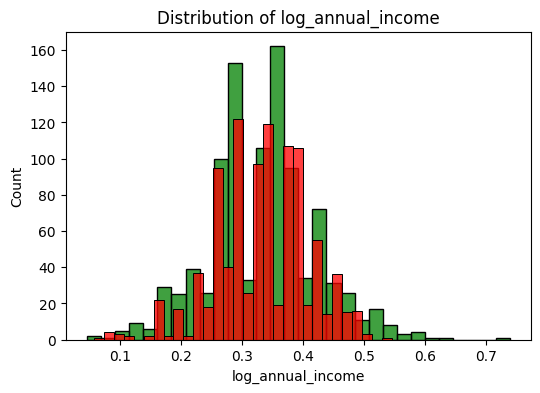

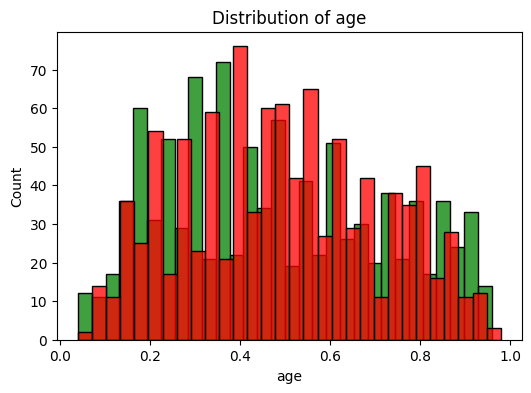

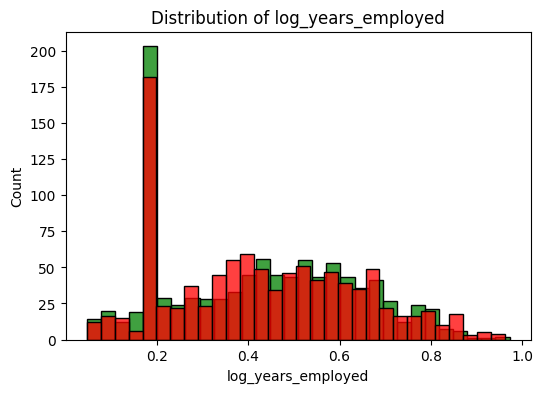

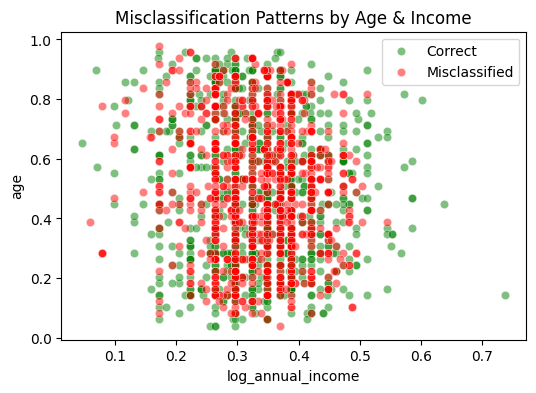

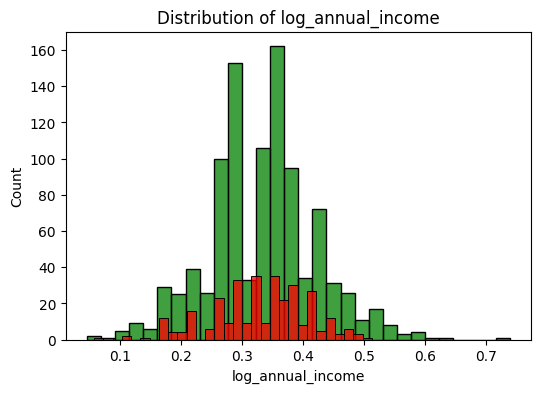

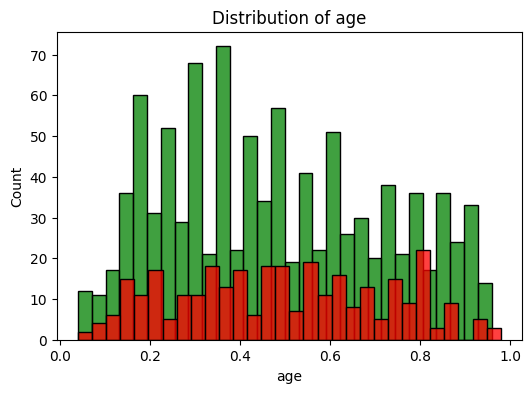

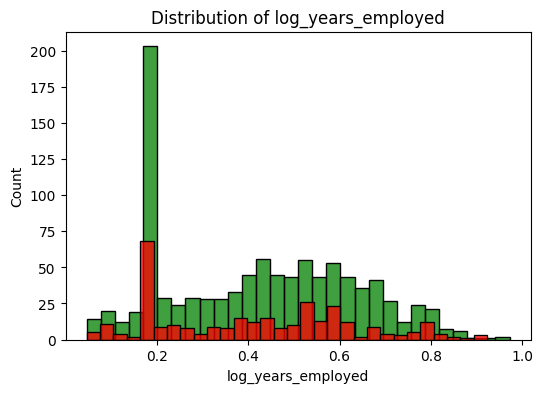

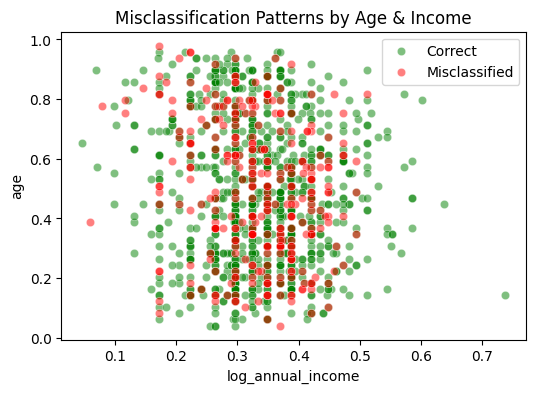

gender                                                 1
own_car                                                0
own_realty                                             0
work_phone                                             1
phone                                                  0
email                                                  0
family_size                                          4.0
age                                             0.346939
log_annual_income                               0.368794
log_years_employed                              0.534311
income_type_Pensioner                              False
income_type_State servant                          False
income_type_Student                                False
income_type_Working                                 True
education_type_Higher education                    False
education_type_Incomplete higher                   False
education_type_Lower secondary                      True
education_type_Secondary / seco

In [4]:
#for microscopic evaluation
import seaborn as sns
import matplotlib.pyplot as plt

#get index of misclassfied points
y_pred = y_pred_custom
y_true = y_test_binary
misclassified_ind = []
for i in range(len(y_pred)):
    if y_pred[i] != y_true.iloc[i]:
        misclassified_ind.append(X_test_reduced.index[i])
#create a misclassified df where there is all the misclassified data
misclassified_df = X_test_reduced.loc[misclassified_ind].copy()
misclassified_df['Prediction'] = y_pred[[X_test.index.get_loc(i) for i in misclassified_ind]]
misclassified_df['Actual'] = y_test.loc[misclassified_ind].values
#print(misclassified_df.head(10))

#get the correct samples to make comparision
classified_ind = []
for i in range(len(y_pred)):
    if y_pred[i] == y_true.iloc[i]:
        classified_ind.append(X_test_reduced.index[i])
#create a misclassified df where there is all the misclassified data
classified_df = X_test_reduced.loc[classified_ind].copy()
classified_df['Prediction'] = y_pred[[X_test.index.get_loc(i) for i in classified_ind]]
classified_df['Actual'] = y_test.loc[classified_ind].values
#print(classified_df.head(10))

sample_correct = classified_df.sample(1000, random_state=42)
sample_incorrect = misclassified_df.sample(1000, random_state=42)

#examining according to feature importance
for col in ['log_annual_income', 'age', 'log_years_employed']:
    plt.figure(figsize=(6, 4))
    sns.histplot(sample_correct[col], bins = 30, color='green')
    sns.histplot(sample_incorrect[col], bins = 30, color='red')
    plt.title(f'Distribution of {col}')
    plt.show()

#combining features
#top 2 based on feature importance
plt.figure(figsize=(6, 4))
sns.scatterplot(data=sample_correct, x='log_annual_income', y='age', color='green', label='Correct', alpha=0.5)
sns.scatterplot(data=sample_incorrect, x='log_annual_income', y='age', color='red', label='Misclassified', alpha=0.5)
plt.title("Misclassification Patterns by Age & Income")
plt.legend()
plt.show()

#examining false positive
fp_points = misclassified_df[misclassified_df['Actual'] == 1]

for col in ['log_annual_income', 'age', 'log_years_employed']:
    plt.figure(figsize=(6, 4))
    sns.histplot(sample_correct[col], bins = 30, color='green')
    sns.histplot(fp_points[col], bins = 30, color='red')
    plt.title(f'Distribution of {col}')
    plt.show()

#print(fp_points.head(10))
plt.figure(figsize=(6, 4))
sns.scatterplot(data=sample_correct, x='log_annual_income', y='age', color='green', label='Correct', alpha=0.5)
sns.scatterplot(data=fp_points, x='log_annual_income', y='age', color='red', label='Misclassified', alpha=0.5)
plt.title("Misclassification Patterns by Age & Income")
plt.legend()
plt.show()

#finding exact points in dense areas that are misclassified and classified
#using one point of false positive as an example and comparing to positive
subset_correct = sample_correct[(sample_correct['log_annual_income'] >= 0.36) & (sample_correct['log_annual_income'] <= 0.38) & (sample_correct['age'] <= 0.35) & (sample_correct['age'] > 0.34)]
subset_fp_points = fp_points[(fp_points['log_annual_income'] >= 0.36) & (fp_points['log_annual_income'] <= 0.38)]
print(subset_fp_points.iloc[1])
print(subset_correct)